In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.layers import *
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as MSE, mean_absolute_error as MAE
from keras.optimizers import Adam, SGD

In [2]:
def correct_datetime(df):
    date = datetime.strptime(df, '%b %d, %Y')
    return date.strftime("%Y-%m-%d")

In [3]:
wmt_df = pd.read_csv('../input/wallmartstockprice/WMT Historical Data.csv', sep=',')
wmt_df['Date'] = wmt_df['Date'].apply(lambda x: correct_datetime(x))
wmt_df = wmt_df.sort_values('Date').reset_index(drop=True)

In [4]:
wmt_df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2013-08-15,74.41,74.46,75.08,74.03,13.22M,-2.60%
1,2013-08-16,74.11,74.12,74.50,73.70,7.25M,-0.40%
2,2013-08-19,73.58,73.88,73.93,73.21,5.36M,-0.72%
3,2013-08-20,73.23,73.55,73.62,73.20,6.66M,-0.48%
4,2013-08-21,73.55,73.16,74.13,72.93,8.08M,0.44%


In [5]:
wmt_df.shape

(2266, 7)

In [6]:
wmt_df['Price'] = wmt_df['Price'].astype(float)

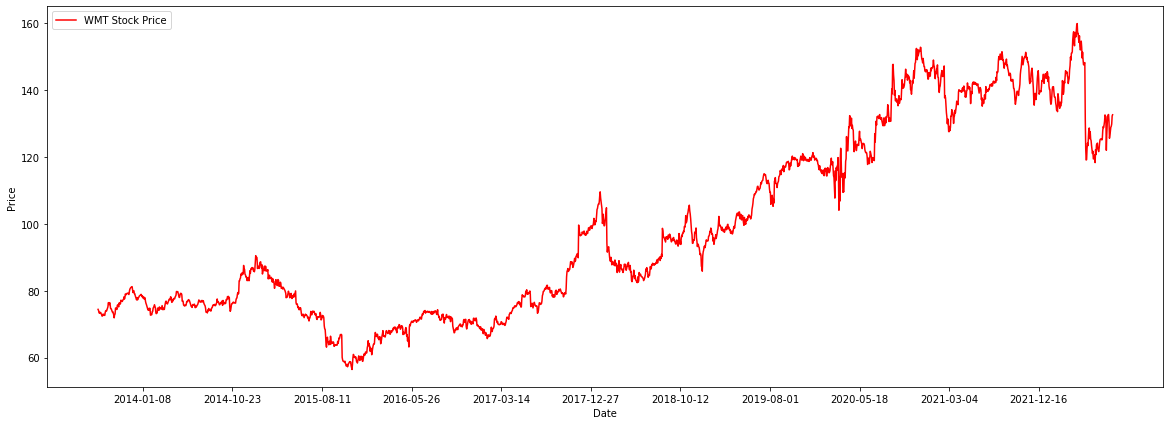

In [7]:
plt.figure(figsize=(20,7))
plt.plot(wmt_df['Date'].values, wmt_df['Price'].values, label = 'WMT Stock Price', color = 'red')
plt.xticks(np.arange(100,wmt_df.shape[0],200))
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Data preparation

In [8]:
num_shape = int(0.8*wmt_df.shape[0])

train = wmt_df.iloc[:num_shape, 1:2].values
val = wmt_df.iloc[num_shape:, 1:2].values

In [9]:
# Scaling our features using normalization. 
# Normalizing data helps the algorithm in converging i.e. to find local/ global minimum efficiently.

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)

In [10]:
X_train = []

#Price on next day
y_train = []

window = 60

for i in range(window, num_shape):
    X_train_ = np.reshape(train_scaled[i-window:i, 0], (window, 1))
    X_train.append(X_train_)
    y_train.append(train_scaled[i, 0])
X_train = np.stack(X_train)
y_train = np.stack(y_train)

# LSTM



In [11]:
# Let's define the architecture using LSTM

LSTM_model = Sequential()

LSTM_model.add(LSTM(60, return_sequences = True, input_shape = (X_train.shape[1], 1)))
LSTM_model.add(Dropout(0.2))

LSTM_model.add(LSTM(60))
LSTM_model.add(Dropout(0.2))

# Adding the output layer
LSTM_model.add(Dense(units = 1))
LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 60)            14880     
_________________________________________________________________
dropout (Dropout)            (None, 60, 60)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60)                29040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 61        
Total params: 43,981
Trainable params: 43,981
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Training

LSTM_model.compile(
    optimizer = 'adam', 
    loss = 'mean_absolute_error'
)

LSTM_model.fit(X_train, 
          y_train, 
          epochs = 50, 
          batch_size = 32,
          )

Epoch 1/50
55/55 [==============================] - 0s 7ms/step - loss: 0.1716
Epoch 2/50
55/55 [==============================] - 0s 7ms/step - loss: 0.1082
Epoch 3/50
55/55 [==============================] - 0s 6ms/step - loss: 0.1020
Epoch 4/50
55/55 [==============================] - 0s 7ms/step - loss: 0.1002
Epoch 5/50
55/55 [==============================] - 0s 7ms/step - loss: 0.0954
Epoch 6/50
55/55 [==============================] - 0s 7ms/step - loss: 0.0908
Epoch 7/50
55/55 [==============================] - 0s 7ms/step - loss: 0.0959
Epoch 8/50
55/55 [==============================] - 0s 6ms/step - loss: 0.0890
Epoch 9/50
55/55 [==============================] - 0s 7ms/step - loss: 0.0856
Epoch 10/50
55/55 [==============================] - 0s 8ms/step - loss: 0.0863
Epoch 11/50
55/55 [==============================] - 0s 8ms/step - loss: 0.0888
Epoch 12/50
55/55 [==============================] - 0s 7ms/step - loss: 0.0895
Epoch 13/50
55/55 [==============================

In [13]:
df_volume = np.vstack((train, val))

inputs = df_volume[df_volume.shape[0] - val.shape[0] - window:]
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

num_2 = df_volume.shape[0] - num_shape + window

X_val = []

for i in range(window, num_2):
    X_val_ = np.reshape(inputs[i-window:i, 0], (window, 1))
    X_val.append(X_val_)
    
X_val = np.stack(X_val)

In [14]:
LSTM_predict = LSTM_model.predict(X_val)
LSTM_predict = scaler.inverse_transform(LSTM_predict)

In [15]:
# MSE and MAE for LSTM prediction

print("LSTM MSE:", MSE(LSTM_predict,val))
print("LSTM MAE:", MAE(LSTM_predict,val))

LSTM MSE: 4.514539525800846
LSTM MAE: 1.4230135375707684


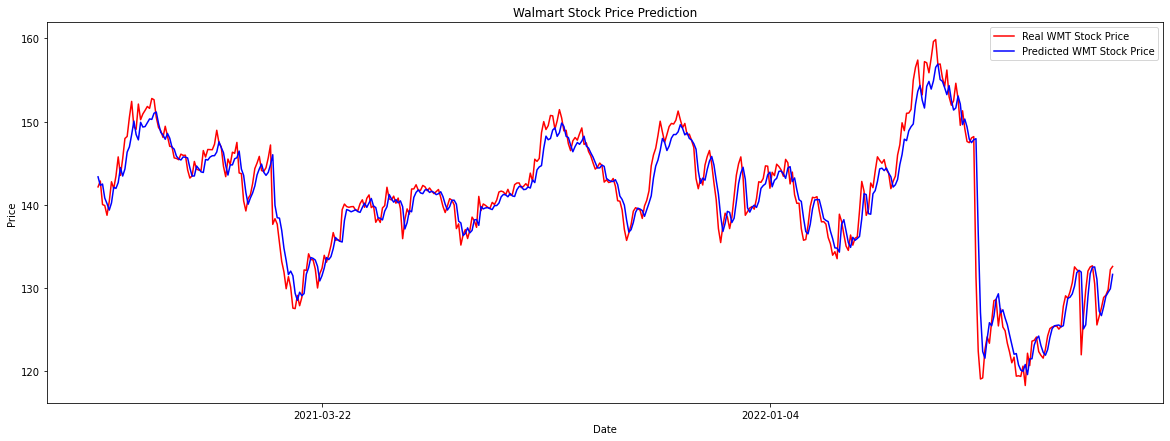

In [16]:
plt.figure(figsize=(20,7))
plt.plot(wmt_df['Date'].values[num_shape:], df_volume[num_shape:], color = 'red', label = 'Real WMT Stock Price')
plt.plot(wmt_df['Date'][-LSTM_predict.shape[0]:].values, LSTM_predict, color = 'blue', label = 'Predicted WMT Stock Price')
plt.xticks(np.arange(100,wmt_df[num_shape:].shape[0],200))
plt.title('Walmart Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## LSTM 30-day forecast

In [17]:
LSTM_pred_ = LSTM_predict[-1].copy()
prediction_full = []
window = 60
df_copy = wmt_df.iloc[:, 1:2][1:].values

for j in range(20):
    df_ = np.vstack((df_copy, LSTM_pred_))
    train_ = df_[:num_shape]
    test_ = df_[num_shape:]
    
    df_volume_ = np.vstack((train_, test_))

    inputs_ = df_volume_[df_volume_.shape[0] - test_.shape[0] - window:]
    inputs_ = inputs_.reshape(-1,1)
    inputs_ = scaler.transform(inputs_)

    X_test_2 = []

    for k in range(window, num_2):
        X_test_3 = np.reshape(inputs_[k-window:k, 0], (window, 1))
        X_test_2.append(X_test_3)

    X_test_ = np.stack(X_test_2)
    LSTM_predict_ = LSTM_model.predict(X_test_)
    LSTM_pred_ = scaler.inverse_transform(LSTM_predict_)
    prediction_full.append(LSTM_pred_[-1][0])
    df_copy = df_[j:]

In [18]:
LSTM_prediction_full_new = np.vstack((LSTM_predict, np.array(prediction_full).reshape(-1,1)))

In [19]:
df_date = wmt_df[['Date']]

for h in range(20):
    df_date_add = pd.to_datetime(df_date['Date'].iloc[-1]) + pd.DateOffset(days=1)
    df_date_add = pd.DataFrame([df_date_add.strftime("%Y-%m-%d")], columns=['Date'])
    df_date = df_date.append(df_date_add)
df_date = df_date.reset_index(drop=True)

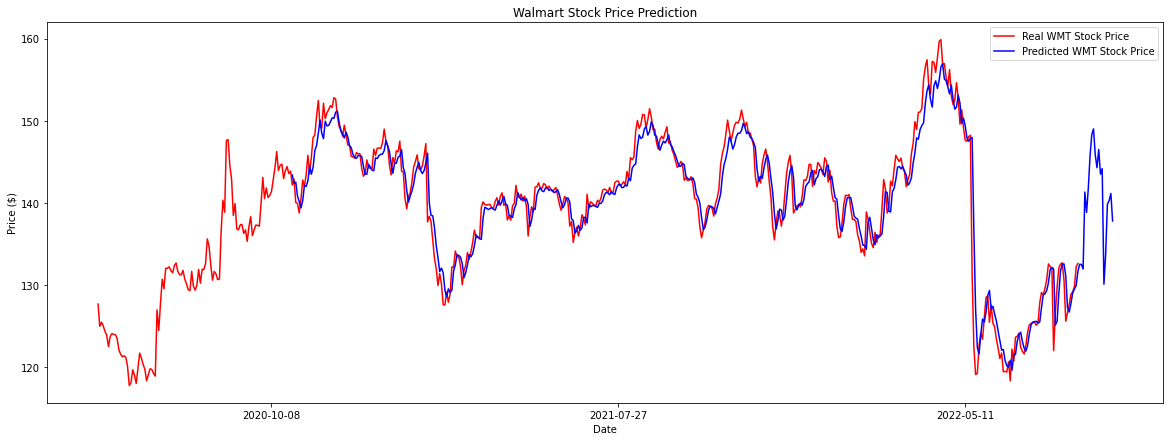

In [20]:
plt.figure(figsize=(20,7))
plt.plot(wmt_df['Date'].values[1700:], df_volume[1700:], color = 'red', label = 'Real WMT Stock Price')
plt.plot(df_date['Date'][-LSTM_prediction_full_new.shape[0]:].values, LSTM_prediction_full_new, color = 'blue', label = 'Predicted WMT Stock Price')
plt.xticks(np.arange(100,wmt_df[1700:].shape[0],200))
plt.title('Walmart Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

# GRU

In [21]:
# Let's define the architecture using GRU

GRU_model = Sequential()

GRU_model.add(GRU(60, return_sequences=True, input_shape=(X_train.shape[1],1)))
GRU_model.add(Dropout(0.2))

GRU_model.add(GRU(60))
GRU_model.add(Dropout(0.2))

GRU_model.add(Dense(units=1))
GRU_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 60, 60)            11340     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 60)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 60)                21960     
_________________________________________________________________
dropout_3 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 61        
Total params: 33,361
Trainable params: 33,361
Non-trainable params: 0
_________________________________________________________________


In [22]:
#Training

GRU_model.compile(optimizer='adam', loss='mean_absolute_error')
GRU_model.fit(X_train, 
             y_train, 
             epochs=50, 
             batch_size=32)

Epoch 1/50
55/55 [==============================] - 0s 6ms/step - loss: 0.1682
Epoch 2/50
55/55 [==============================] - 0s 6ms/step - loss: 0.0926
Epoch 3/50
55/55 [==============================] - 0s 6ms/step - loss: 0.0855
Epoch 4/50
55/55 [==============================] - 0s 9ms/step - loss: 0.0846
Epoch 5/50
55/55 [==============================] - 1s 9ms/step - loss: 0.0851
Epoch 6/50
55/55 [==============================] - 1s 9ms/step - loss: 0.0823
Epoch 7/50
55/55 [==============================] - 0s 8ms/step - loss: 0.0847
Epoch 8/50
55/55 [==============================] - 0s 6ms/step - loss: 0.0775
Epoch 9/50
55/55 [==============================] - 0s 6ms/step - loss: 0.0792
Epoch 10/50
55/55 [==============================] - 0s 6ms/step - loss: 0.0752
Epoch 11/50
55/55 [==============================] - 0s 6ms/step - loss: 0.0743
Epoch 12/50
55/55 [==============================] - 0s 6ms/step - loss: 0.0749
Epoch 13/50
55/55 [==============================

In [23]:
GRU_predict = GRU_model.predict(X_val)
GRU_predict = scaler.inverse_transform(GRU_predict)

In [24]:
#MSE and MAE for GRU prediction

print("GRU MSE:", MSE(GRU_predict,val))
print("GRU MAE:", MAE(GRU_predict,val))

GRU MSE: 9.328680936580561
GRU MAE: 2.4911479368503926


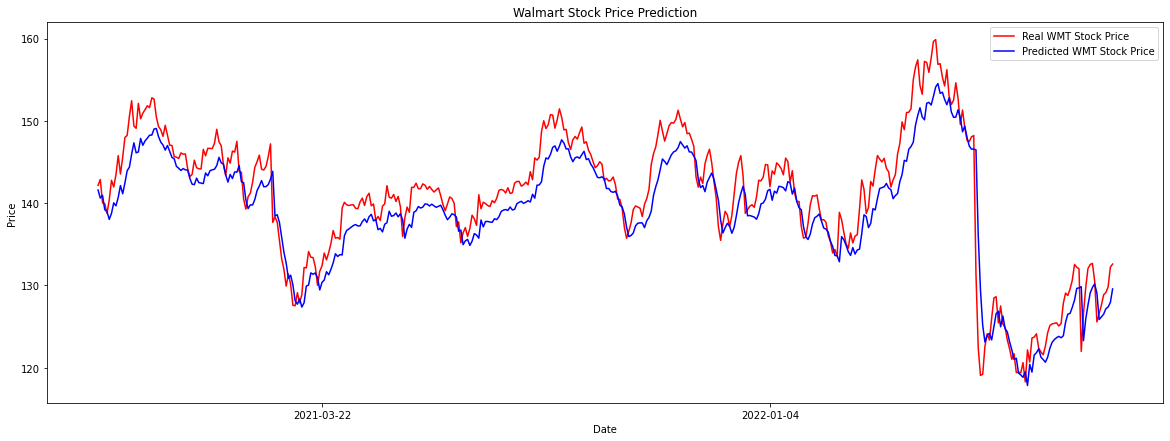

In [25]:
plt.figure(figsize=(20,7))
plt.plot(wmt_df['Date'].values[num_shape:], df_volume[num_shape:], color = 'red', label = 'Real WMT Stock Price')
plt.plot(wmt_df['Date'][-GRU_predict.shape[0]:].values, GRU_predict, color = 'blue', label = 'Predicted WMT Stock Price')
plt.xticks(np.arange(100,wmt_df[num_shape:].shape[0],200))
plt.title('Walmart Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## GRU 30-day forecast

In [26]:
GRU_pred_ = GRU_predict[-1].copy()
GRU_prediction_full = []
window = 60
df_copy = wmt_df.iloc[:, 1:2][1:].values

for j in range(20):
    df_ = np.vstack((df_copy, GRU_pred_))
    train_ = df_[:num_shape]
    test_ = df_[num_shape:]
    
    df_volume_ = np.vstack((train_, test_))

    inputs_ = df_volume_[df_volume_.shape[0] - test_.shape[0] - window:]
    inputs_ = inputs_.reshape(-1,1)
    inputs_ = scaler.transform(inputs_)

    X_test_2 = []

    for k in range(window, num_2):
        X_test_3 = np.reshape(inputs_[k-window:k, 0], (window, 1))
        X_test_2.append(X_test_3)

    X_test_ = np.stack(X_test_2)
    GRU_predict_ = GRU_model.predict(X_test_)
    GRU_pred_ = scaler.inverse_transform(GRU_predict_)
    GRU_prediction_full.append(GRU_pred_[-1][0])
    df_copy = df_[j:]

In [27]:
GRU_prediction_full_new = np.vstack((GRU_predict, np.array(GRU_prediction_full).reshape(-1,1)))

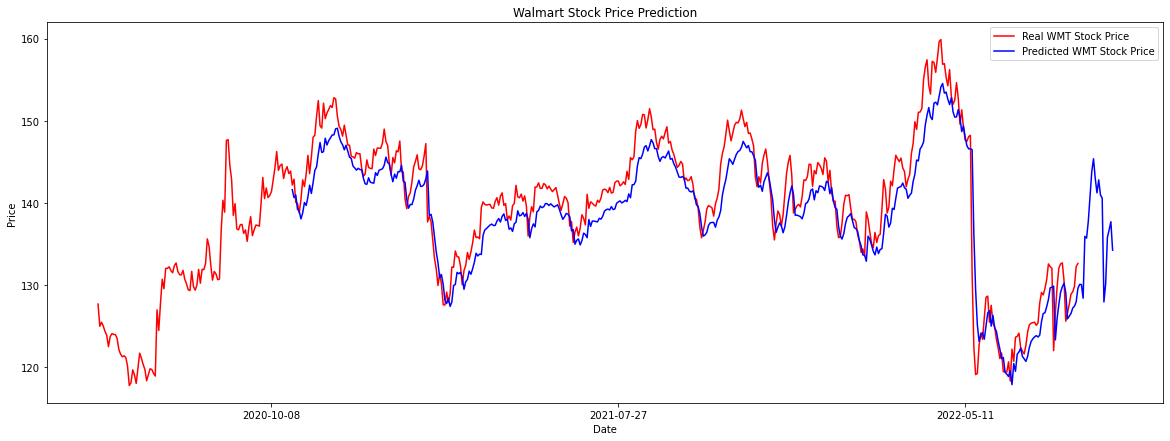

In [28]:
plt.figure(figsize=(20,7))
plt.plot(wmt_df['Date'].values[1700:], df_volume[1700:], color = 'red', label = 'Real WMT Stock Price')
plt.plot(df_date['Date'][-GRU_prediction_full_new.shape[0]:].values, GRU_prediction_full_new, color = 'blue', label = 'Predicted WMT Stock Price')
plt.xticks(np.arange(100,wmt_df[1700:].shape[0],200))
plt.title('Walmart Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# LSTM and GRU comparison (30-day forecast)

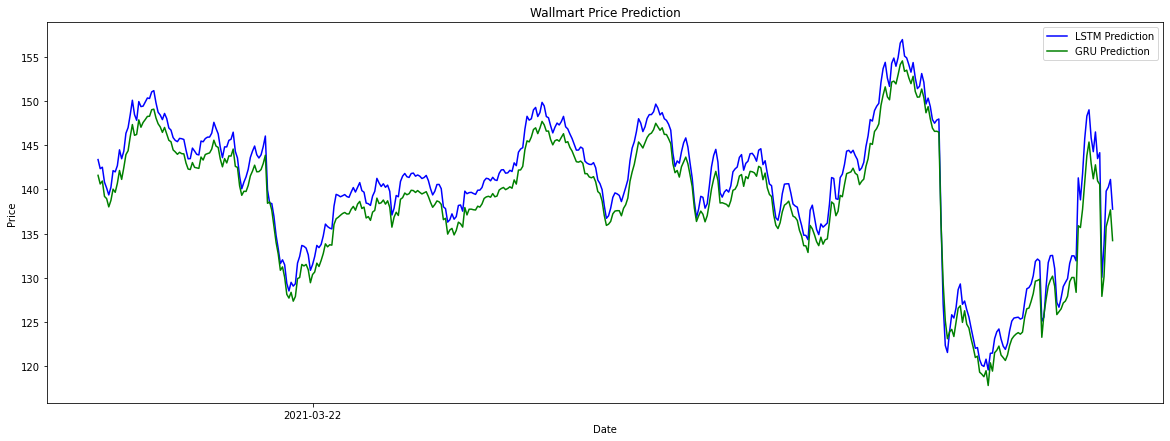

In [29]:
plt.figure(figsize=(20,7))
plt.plot(df_date['Date'][-LSTM_prediction_full_new.shape[0]:].values, LSTM_prediction_full_new, color = 'blue', label = 'LSTM Prediction')
plt.plot(df_date['Date'][-GRU_prediction_full_new.shape[0]:].values, GRU_prediction_full_new, color = 'green', label = 'GRU Prediction')
plt.xticks(np.arange(100,df_date[2000:].shape[0],200))
plt.title('Wallmart Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()